In [1]:
%env NX_CUGRAPH_AUTOCONFIG=True

env: NX_CUGRAPH_AUTOCONFIG=True


In [2]:
!pip install igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle
import igraph as ig
import leidenalg as la
import seaborn as sns

In [4]:
def load_community_result(*args):
    """Load community results from pickle files."""
    communities = []
    for file in args:
        with open(file, 'rb') as f:
            communities.append(pickle.load(f))
    return communities

def calculate_community_quality(G, community):
    """Calculates quality metrics for a given community structure in a graph.

    This function computes three common metrics to assess the quality of a
    community partition in a graph: modularity, coverage, and performance.

    Modularity measures the strength of division of a network into communities.
    It quantifies the difference between the fraction of edges within communities
    and the expected fraction if edges were distributed at random. Higher
    modularity values (closer to 1) generally indicate better community structure.

    Coverage is the fraction of edges that fall within communities. It measures
    how much of the network's connectivity is captured by the identified
    communities. Higher coverage is generally desirable.

    Performance is a metric that combines coverage and the fraction of vertices
    in communities. It is designed to be less sensitive to the number of
    communities and the size of the graph than coverage alone. Higher performance
    values are generally better.

    Args:
        G (nx.Graph): The NetworkX graph for which to calculate community quality.
        community (list of set): A list of sets, where each set represents a
            community and contains the nodes belonging to that community.
            For example: `[{1, 2, 3}, {4, 5}]` represents two communities.

    Returns:
        dict: A dictionary containing the calculated community quality metrics.
              The dictionary has the following keys:
                - 'modularity' (float): The modularity score of the community structure.
                - 'coverage' (float): The coverage score of the community structure.
                - 'performance' (float): The performance score of the community structure.

    Examples:
        >>> import networkx as nx
        >>> G = nx.karate_club_graph()
        >>> community = [{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21}, {9, 14, 15, 16, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]
        >>> quality_metrics = calculate_community_quality(G, community)
        >>> print(quality_metrics)
        {'modularity': 0.3792373075876584, 'coverage': 0.77875, 'performance': 0.6007444168734458}
    """
    modularity = nx.community.modularity(G, community)
    community_quality_result = nx.community.partition_quality(G, community)
    return {
        'modularity': modularity,
        'coverage': community_quality_result[0],
        'performance': community_quality_result[1],
    }

def analyze_community_sizes(communities):
    """
    Analyze community sizes when communities are provided as a list of sets
    """
    # Calculate size of each community
    sizes = [len(community) for community in communities]

    return {
        'total_communities': len(communities),
        'largest_community': max(sizes),
        'smallest_community': min(sizes),
        'average_size': np.mean(sizes),
        'median_size': np.median(sizes),
        'size_distribution': sizes
    }

def visualize_community_sample(G, communities, method_name, max_nodes=500):
    """
    Visualize sample of largest and medium communities with directed edges and nodes colored by group
    communities: list of sets where each set contains nodes of one community
    """
    sorted_communities = sorted(communities, key=len, reverse=True)

    # Get top 3 largest communities
    largest_communities = sorted_communities[:3]

    # Get 3 communities from the middle
    middle_idx = len(sorted_communities) // 2
    middle_communities = sorted_communities[middle_idx-1:middle_idx+2]

    # Define color mapping for different product groups
    group_colors = {
        'Book': 'royalblue',
        'Music': 'limegreen',
        'DVD': 'crimson',
        'Video': 'gold',
        'Software': 'purple',
        'CE': 'orange',
        'Baby Product': 'pink',
        'Toy': 'cyan',
        'Video Games': 'darkgreen'
    }
    # Default color for unknown groups
    default_color = 'lightgray'

    plt.figure(figsize=(18, 10), facecolor='white')

    # Function to draw a single community subplot
    def draw_community(community, subplot_idx, label):
        plt.subplot(2, 3, subplot_idx)

        # Get nodes in this community
        nodes = list(community)

        # If too many nodes, sample them
        if len(nodes) > max_nodes:
            nodes = np.random.choice(nodes, max_nodes, replace=False)

        # Create subgraph
        subgraph = G.subgraph(nodes)
        pos = nx.spring_layout(subgraph, seed=42)

        # Get node colors based on group attribute
        node_colors = []
        for node in subgraph.nodes():
            try:
                # Try to get group attribute, use default color if not found
                group = G.nodes[node].get('group', None)
                node_colors.append(group_colors.get(group, default_color))
            except:
                node_colors.append(default_color)

        # Draw nodes with group colors
        nx.draw_networkx_nodes(subgraph, pos, node_size=30, node_color=node_colors)

        # Draw directed edges with arrows
        nx.draw_networkx_edges(subgraph, pos, alpha=0.4, width=0.5,
                              arrows=True, arrowsize=10, arrowstyle='->')

        comm_id = list(communities).index(community)
        plt.title(f"{method_name} - {label} Community {comm_id} (n={len(community)})")
        plt.axis('off')

        # Add legend for group colors
        unique_groups = set()
        for node in subgraph.nodes():
            try:
                group = G.nodes[node].get('group', None)
                if group:
                    unique_groups.add(group)
            except:
                pass

        # Create legend with only groups present in this community
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                           markerfacecolor=group_colors.get(group, default_color),
                           label=group, markersize=8)
                           for group in unique_groups]

        if legend_elements:
            plt.legend(handles=legend_elements, loc='upper right', fontsize='x-small')

    # Draw top 3 communities
    for i, community in enumerate(largest_communities):
        draw_community(community, i+1, "Largest")

    # Draw middle 3 communities
    for i, community in enumerate(middle_communities):
        draw_community(community, i+4, "Medium")

    plt.tight_layout()
    plt.show()

In [5]:
df_products = pd.read_csv('products_cleaned_engineered.csv')
df_copurchases = pd.read_csv('copurchase_cleaned.csv')

pickle_file_path = 'amazon_copurchase_graph.pickle'
with open(pickle_file_path, 'rb') as f:
    G = pickle.load(f)
print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

node_num, edge_num = G.number_of_nodes(), G.number_of_edges()

SEED = 28

Loaded graph with 259102 nodes and 1207337 edges


### Notes for algorithm used
* The only direct graph community detection are Louvain, LPA, Greedy, Fluid, Leiden, and Infomap. The rest are approximated by converting the graph into undirected first
* Girvan-Newman, Kernighan-Lin, K-clique, Lukes, etc. aren't used because they are not scalable to large graphs (would take forever)

In [ ]:
louvain_communities = nx.community.louvain_communities(G, seed=SEED)
louvain_partition = nx.community.louvain_partitions(G, seed=SEED)
print(f"Found {len(louvain_communities)} communities using Louvain")

# with open('louvain_communities.pickle', 'wb') as f:
#     pickle.dump(louvain_communities, f)

Found 218 communities using Louvain


In [ ]:
lpa_communities_generator = nx.community.fast_label_propagation_communities(G, seed=SEED)
lpa_communities = list(lpa_communities_generator)
print(f"Found {len(lpa_communities)} communities using LPA")

with open('lpa_communities.pickle', 'wb') as f:
    pickle.dump(lpa_communities, f)

Found 32680 communities using LPA


In [ ]:
# NOTE: Potential for hyperparameter tuning. Params to be tuned:
# - Resolution parameter (resolution=1.0). Try to lower this for larger community (should do it since our graph is very large)
# - best_n (default = None)
# - Curoff (default = 1)
greedy_modularity = nx.community.greedy_modularity_communities(G)
print(f"Found {len(greedy_modularity)} communities using Greedy Modularity")

with open('greedy_modularity.pickle', 'wb') as f:
    pickle.dump(greedy_modularity, f)

Found 1168 communities using Greedy Modularity


In [ ]:
G_undirected = G.to_undirected()

In [ ]:
largest_connected_component_nodes = max(nx.connected_components(G_undirected), key=len)
largest_connected_component = G_undirected.subgraph(largest_connected_component_nodes)

fluid_community = nx.community.asyn_fluidc(largest_connected_component, k=500, seed=SEED)
fluid_community = list(fluid_community)

all_nodes = set(G_undirected.nodes())
lcc_nodes = set(largest_connected_component_nodes)
outside_community_nodes = list(all_nodes - lcc_nodes)

fluid_community.append(set(outside_community_nodes))

with open('fluid_communities.pickle', 'wb') as f:
    pickle.dump(fluid_community, f)

/usr/local/lib/python3.10/dist-packages/networkx/utils/backends.py:1777: UserWarning: Note: conversions to backend graphs are saved to cache (`G.__networkx_cache__` on the original graph) by default.

This warning means the cached graph is being used for the 'cugraph' backend in the call to connected_components.

For the cache to be consistent (i.e., correct), the input graph must not have been manually mutated since the cached graph was created. Examples of manually mutating the graph data structures resulting in an inconsistent cache include:

    >>> G[u][v][key] = val

and

    >>> for u, v, d in G.edges(data=True):
    ...     d[key] = val

Using methods such as `G.add_edge(u, v, weight=val)` will correctly clear the cache to keep it consistent. You may also use `G.__networkx_cache__.clear()` to manually clear the cache, or set `G.__networkx_cache__` to None to disable caching for G. Enable or disable caching globally via `nx.config.cache_converted_graphs` config.

To disable this

In [6]:
nodes = list(G.nodes())
node_map = {node: i for i, node in enumerate(nodes)}

# Create igraph graph
igraph_representation = ig.Graph(directed=G.is_directed())
igraph_representation.add_vertices(len(nodes))

# Add edges
edges = [(node_map[u], node_map[v]) for u, v in G.edges()]
igraph_representation.add_edges(edges)

# Add node attributes (including group for visualization)
for node, data in G.nodes(data=True):
    idx = node_map[node]
    for attr, value in data.items():
        if attr == 'group':  # Ensure group attribute is transferred
            igraph_representation.vs[idx][attr] = value

# Store original node IDs for mapping back
igraph_representation.vs['name'] = nodes

igraph_representation = ig.Graph.from_networkx(G)
leiden_partition = la.find_partition(igraph_representation, la.ModularityVertexPartition, n_iterations=-1, seed=SEED)

leiden_communities = []
for community in leiden_partition:
    community_set = {nodes[idx] for idx in community}
    leiden_communities.append(community_set)

print(f"Found {len(leiden_communities)} communities using Leiden algorithm")

with open('leiden_communities.pickle', 'wb') as f:
    pickle.dump(leiden_communities, f)

Found 477 communities using Leiden algorithm


In [7]:
# Buat dictionary komunitas dari hasil Leiden
community_dict = {}  # {product_id: community_id}

for community_id, community in enumerate(leiden_communities):
    for product_id in community:
        community_dict[product_id] = community_id  # Assign each product to a community

# Pastikan df_products memiliki kolom 'id' yang sesuai dengan product_id dalam komunitas
if 'id' not in df_products.columns:
    raise KeyError("Kolom 'id' tidak ditemukan di df_products. Pastikan ini adalah product_id.")

# Tambahkan kolom 'community' ke df_products berdasarkan mapping komunitas
df_products["community"] = df_products["id"].map(community_dict)

# Periksa apakah ada produk yang tidak memiliki komunitas
missing_communities = df_products["community"].isna().sum()
print(f"Jumlah produk tanpa komunitas: {missing_communities}")

# Jika ada yang kosong, isi dengan -1 sebagai kategori "tanpa komunitas"
df_products["community"] = df_products["community"].fillna(-1).astype(int)

print("Kolom 'community' berhasil ditambahkan ke df_products!")

Jumlah produk tanpa komunitas: 65
Kolom 'community' berhasil ditambahkan ke df_products!


In [ ]:
nodes = list(G.nodes())
node_map = {node: i for i, node in enumerate(nodes)}

# Create igraph graph
igraph_representation = ig.Graph(directed=G.is_directed())
igraph_representation.add_vertices(len(nodes))

# Add edges
edges = [(node_map[u], node_map[v]) for u, v in G.edges()]
igraph_representation.add_edges(edges)

# Add node attributes (including group for visualization)
for node, data in G.nodes(data=True):
    idx = node_map[node]
    for attr, value in data.items():
        if attr == 'group':  # Ensure group attribute is transferred
            igraph_representation.vs[idx][attr] = value

# Store original node IDs for mapping back
igraph_representation.vs['name'] = nodes

igraph_representation = ig.Graph.from_networkx(G)
vertex_clustering = igraph_representation.community_infomap(trials=20)

# Convert results to NetworkX format (list of sets)
infomap_communities = []
for cluster in vertex_clustering:
    community_set = {nodes[idx] for idx in cluster}
    infomap_communities.append(community_set)

print(f"Found {len(infomap_communities)} communities using Infomap algorithm")

with open('infomap_communities.pickle', 'wb') as f:
    pickle.dump(infomap_communities, f)

Found 17578 communities using Infomap algorithm


In [8]:
louvain_communities, lpa_communities, greedy_modularity, fluid_community, leiden_communities, infomap_communities = load_community_result('louvain_communities.pickle', 'lpa_communities.pickle', 'greedy_modularity.pickle', 'fluid_communities.pickle', 'leiden_communities.pickle', 'infomap_communities.pickle')

In [9]:
evaluation_df = pd.DataFrame(columns=['method', 'modularity', 'coverage', 'performance'])
statistics_df = pd.DataFrame(columns=['method', 'total_communities', 'largest_community', 'smallest_community', 'average_size', 'median_size', 'size_distribution'])

name_to_community_dict = {
    'Louvain': louvain_communities,
    'LPA': lpa_communities,
    'Greedy Modularity': greedy_modularity,
    'Fluid': fluid_community,
    'Leiden': leiden_communities,
    'Infomap': infomap_communities,
}

for method_name, communities in name_to_community_dict.items():
    # Calculate community quality metrics
    quality_metrics = calculate_community_quality(G, communities)
    row_eval_df = pd.DataFrame([{'method': method_name, **quality_metrics}])
    evaluation_df = pd.concat([evaluation_df, row_eval_df], ignore_index=True)

    # Analyze community sizes
    community_sizes = analyze_community_sizes(communities)
    row_stats_df = pd.DataFrame([{'method': method_name, **community_sizes}])
    statistics_df = pd.concat([statistics_df, row_stats_df], ignore_index=True)

<ipython-input-9-0b7c0a0ac931>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_df = pd.concat([evaluation_df, row_eval_df], ignore_index=True)
<ipython-input-9-0b7c0a0ac931>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  statistics_df = pd.concat([statistics_df, row_stats_df], ignore_index=True)


In [10]:
display(evaluation_df)
display(statistics_df)

,method,modularity,coverage,performance
0,Louvain,0.915720,0.933588,0.982295
1,LPA,0.711033,0.711109,0.999950
2,Greedy Modularity,0.883099,0.935846,0.948647
3,Fluid,0.810303,0.812435,0.997898
4,Leiden,0.923866,0.938456,0.985481
5,Infomap,0.785317,0.785426,0.999922


,method,total_communities,largest_community,smallest_community,average_size,median_size,size_distribution
0,Louvain,218,15988,2,1188.541284,395.0,"[3396, 115, 2302, 3407, 2216, 305, 3738, 1804,..."
1,LPA,32680,471,2,7.928458,6.0,"[8, 10, 22, 9, 25, 8, 24, 5, 49, 8, 43, 9, 12,..."
2,Greedy Modularity,1168,34840,2,221.833904,12.0,"[34840, 31149, 19133, 18446, 9797, 8540, 8084,..."
3,Fluid,501,921,134,517.169661,510.0,"[582, 227, 542, 472, 448, 635, 450, 620, 390, ..."
4,Leiden,477,8664,2,543.190776,19.0,"[8664, 8312, 8305, 7839, 6837, 6809, 5837, 540..."
5,Infomap,17578,250,1,14.740130,12.0,"[2, 19, 90, 29, 31, 8, 32, 62, 56, 98, 68, 10,..."


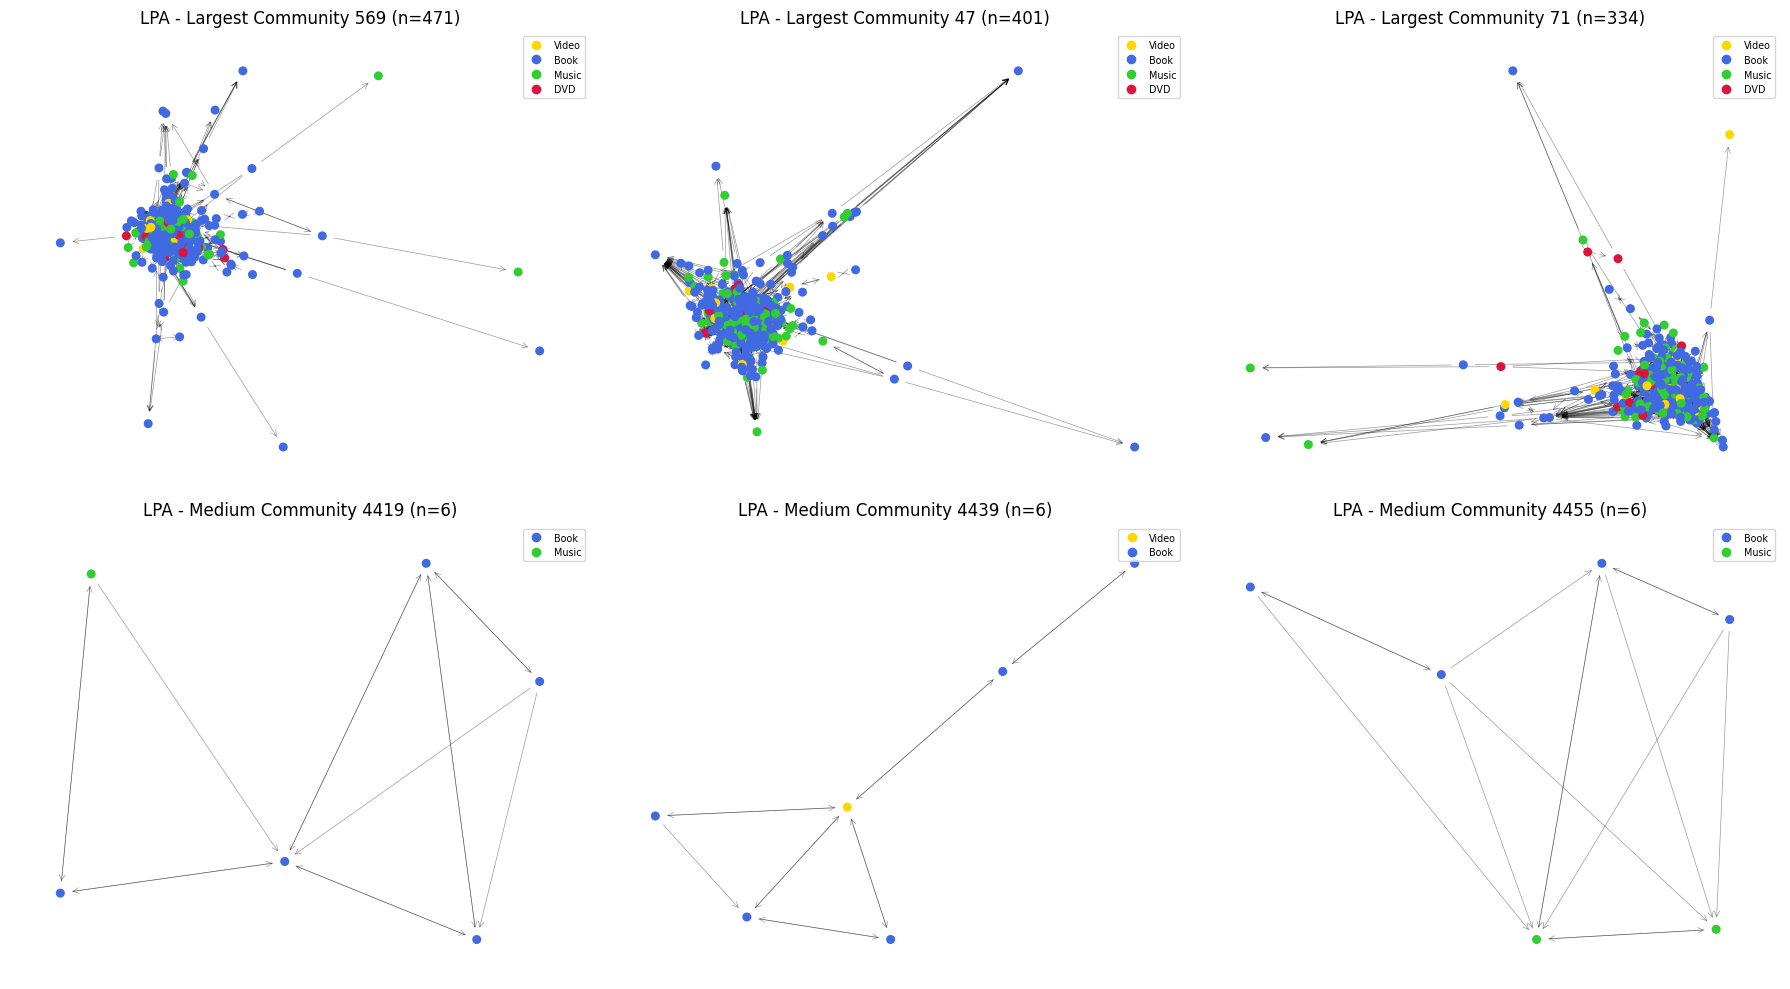

In [11]:
visualize_community_sample(G, lpa_communities, "LPA", max_nodes=500)

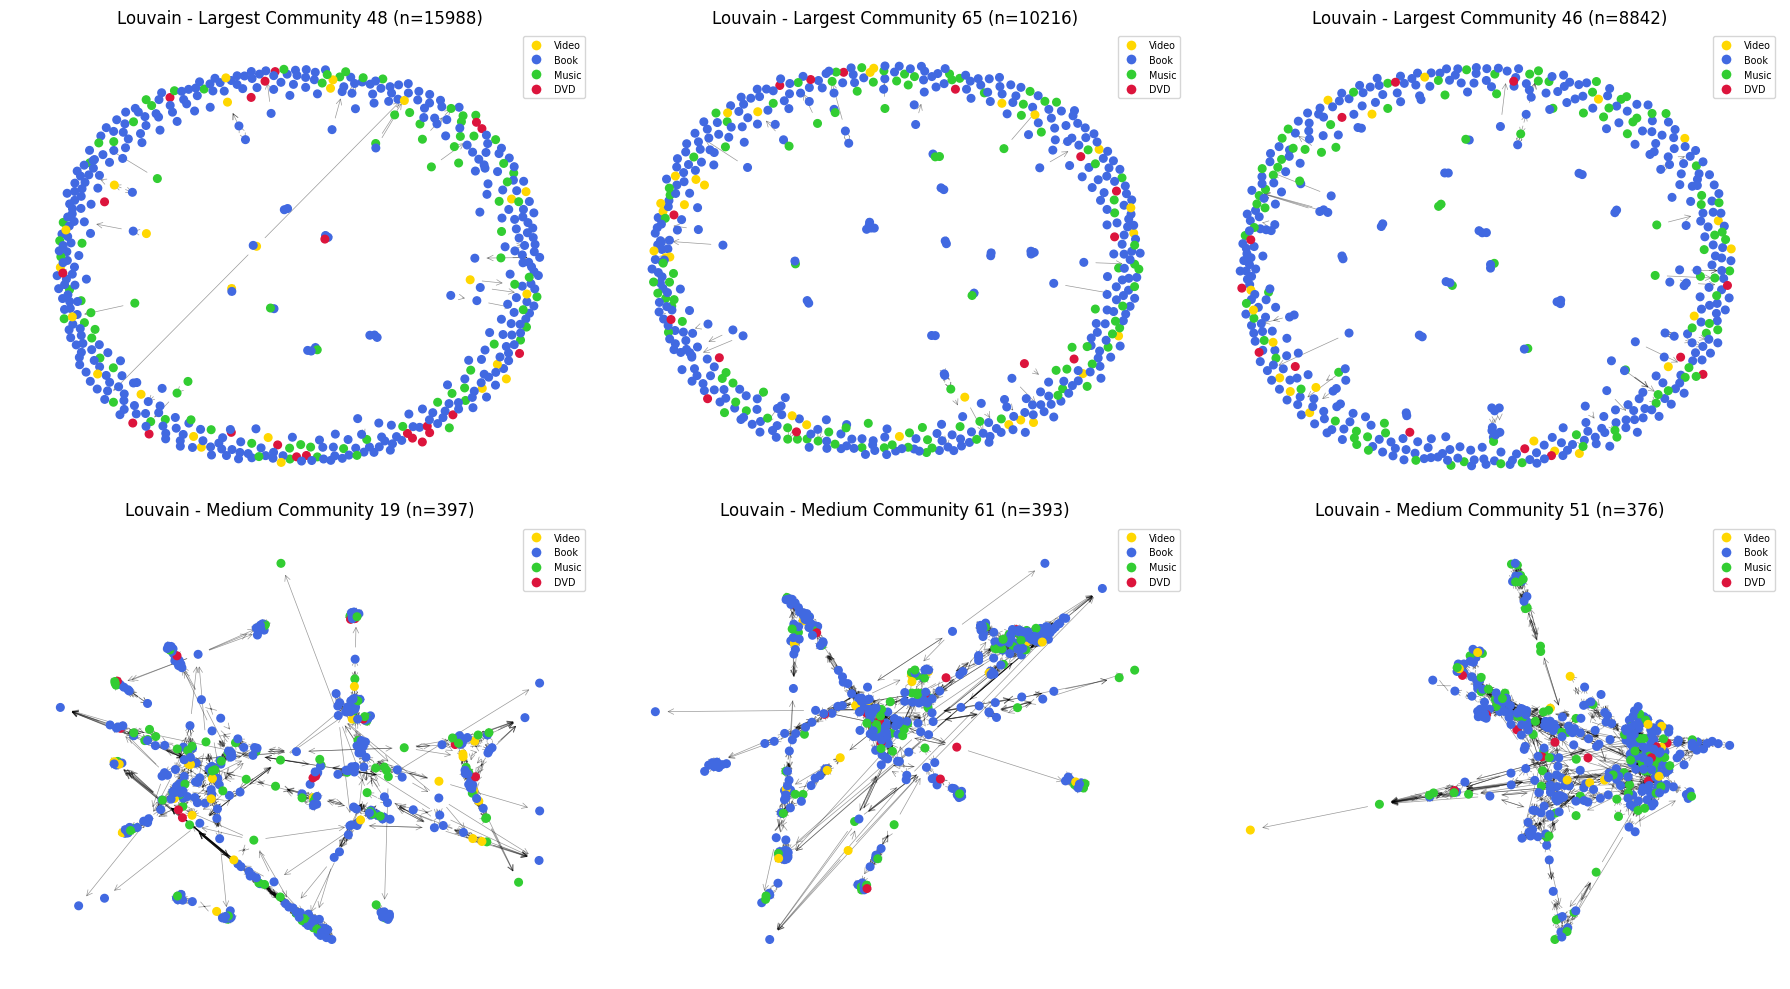

In [12]:
visualize_community_sample(G, louvain_communities, "Louvain", max_nodes=500)

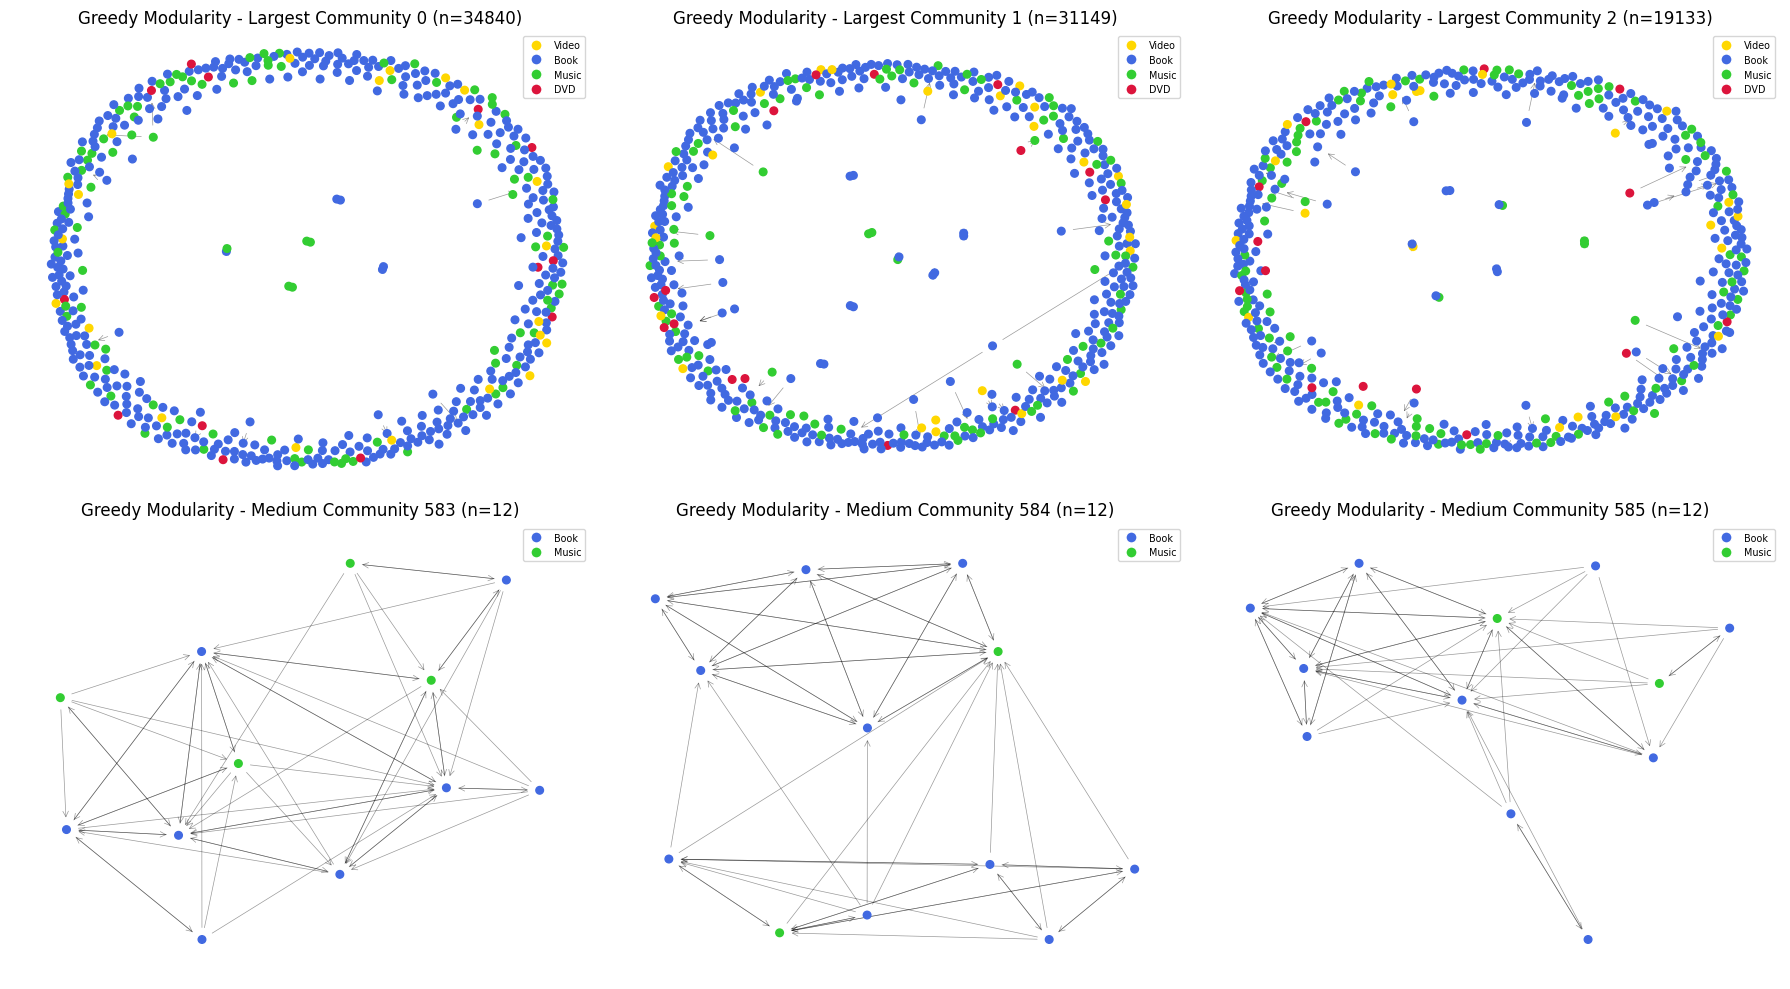

In [13]:
visualize_community_sample(G, greedy_modularity, "Greedy Modularity", max_nodes=500)

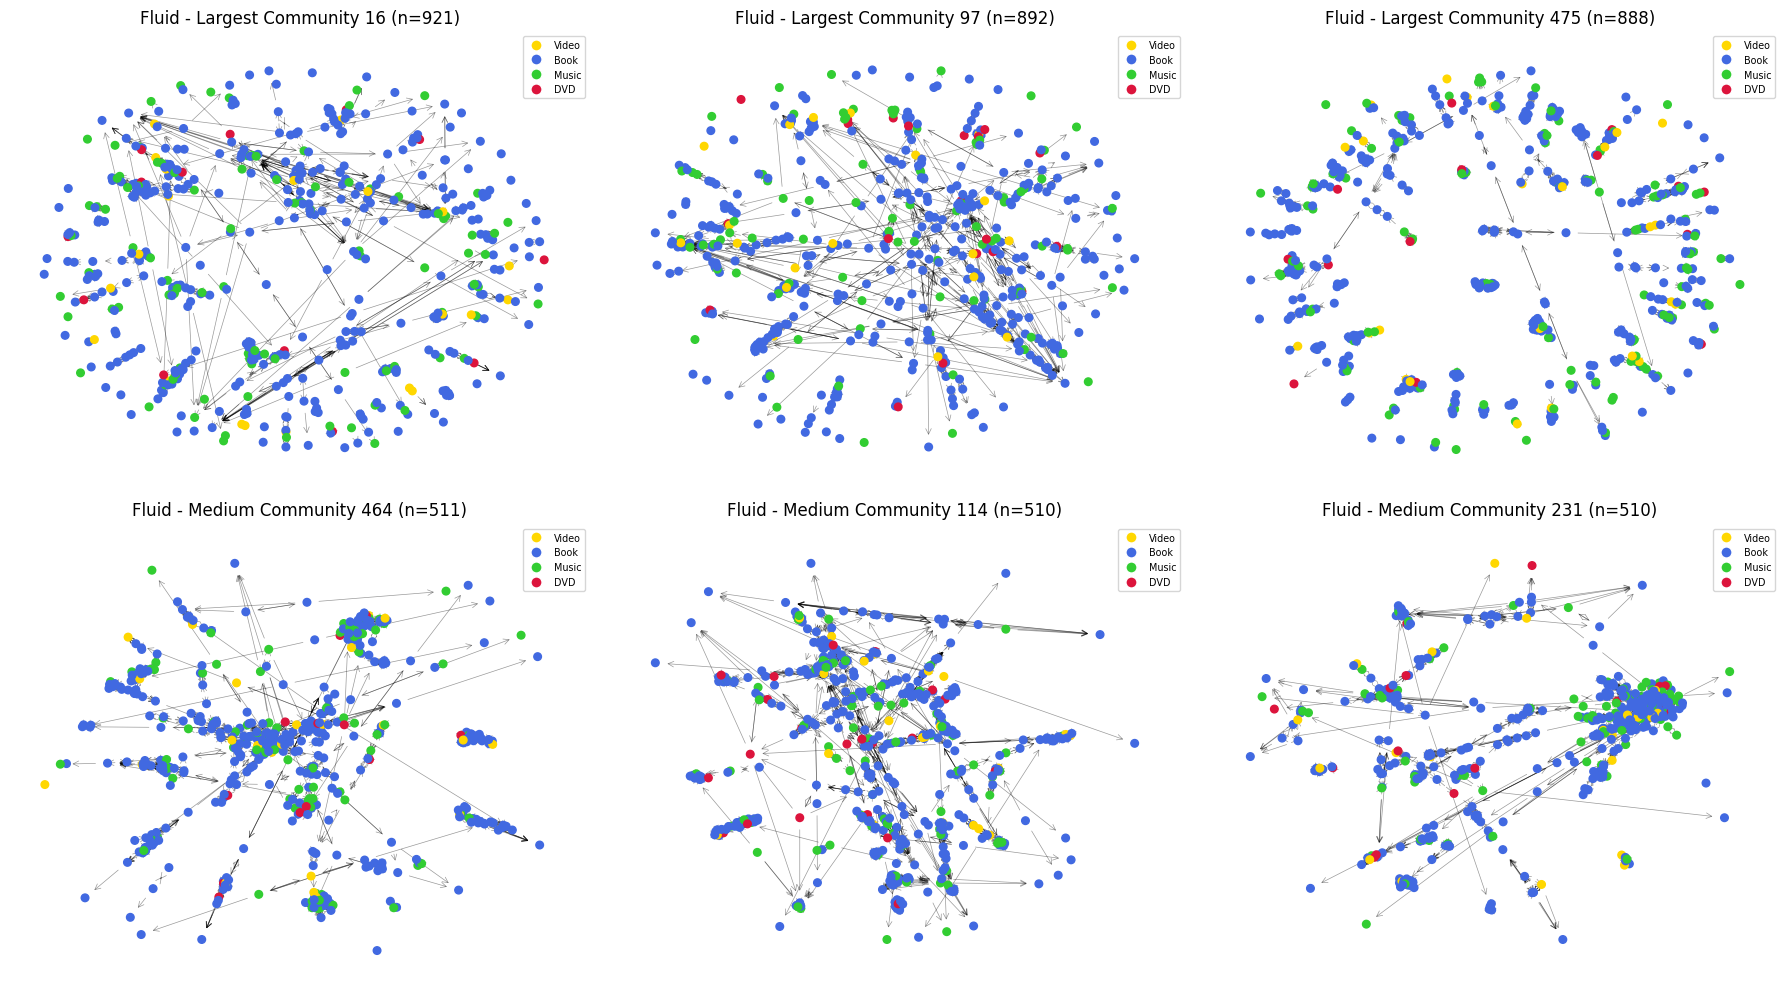

In [14]:
visualize_community_sample(G, fluid_community, "Fluid", max_nodes=500)

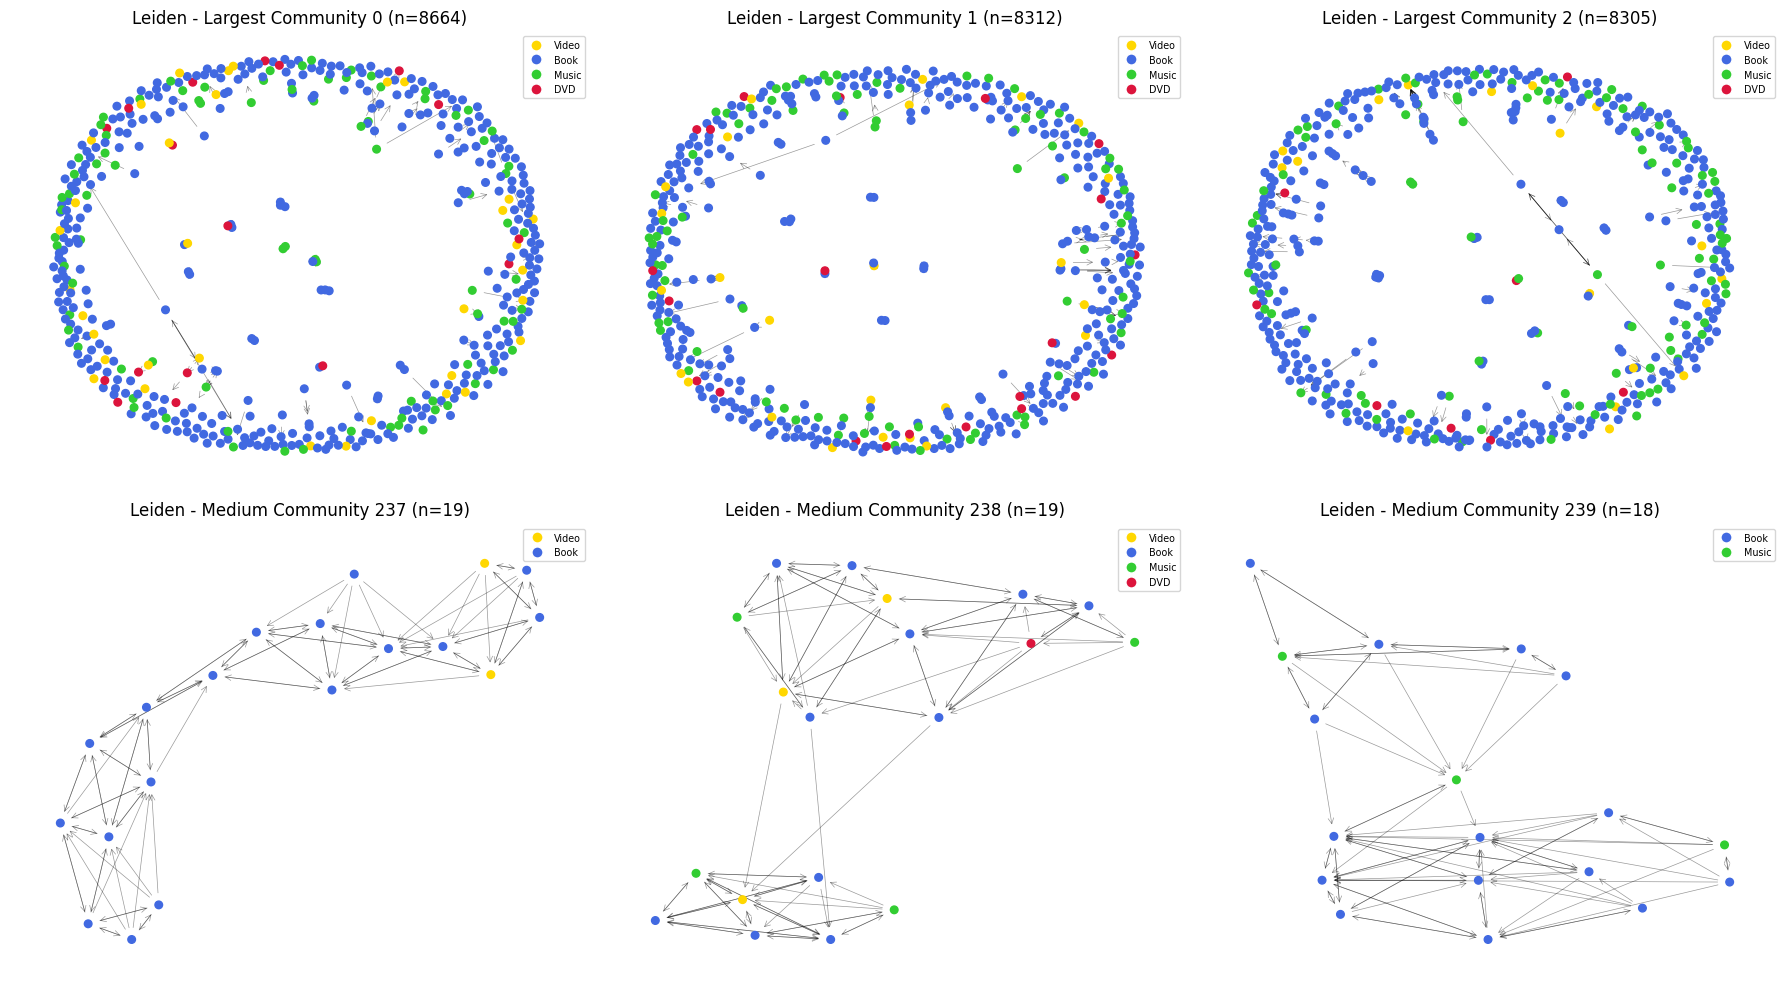

In [15]:
visualize_community_sample(G, leiden_communities, "Leiden", max_nodes=500)

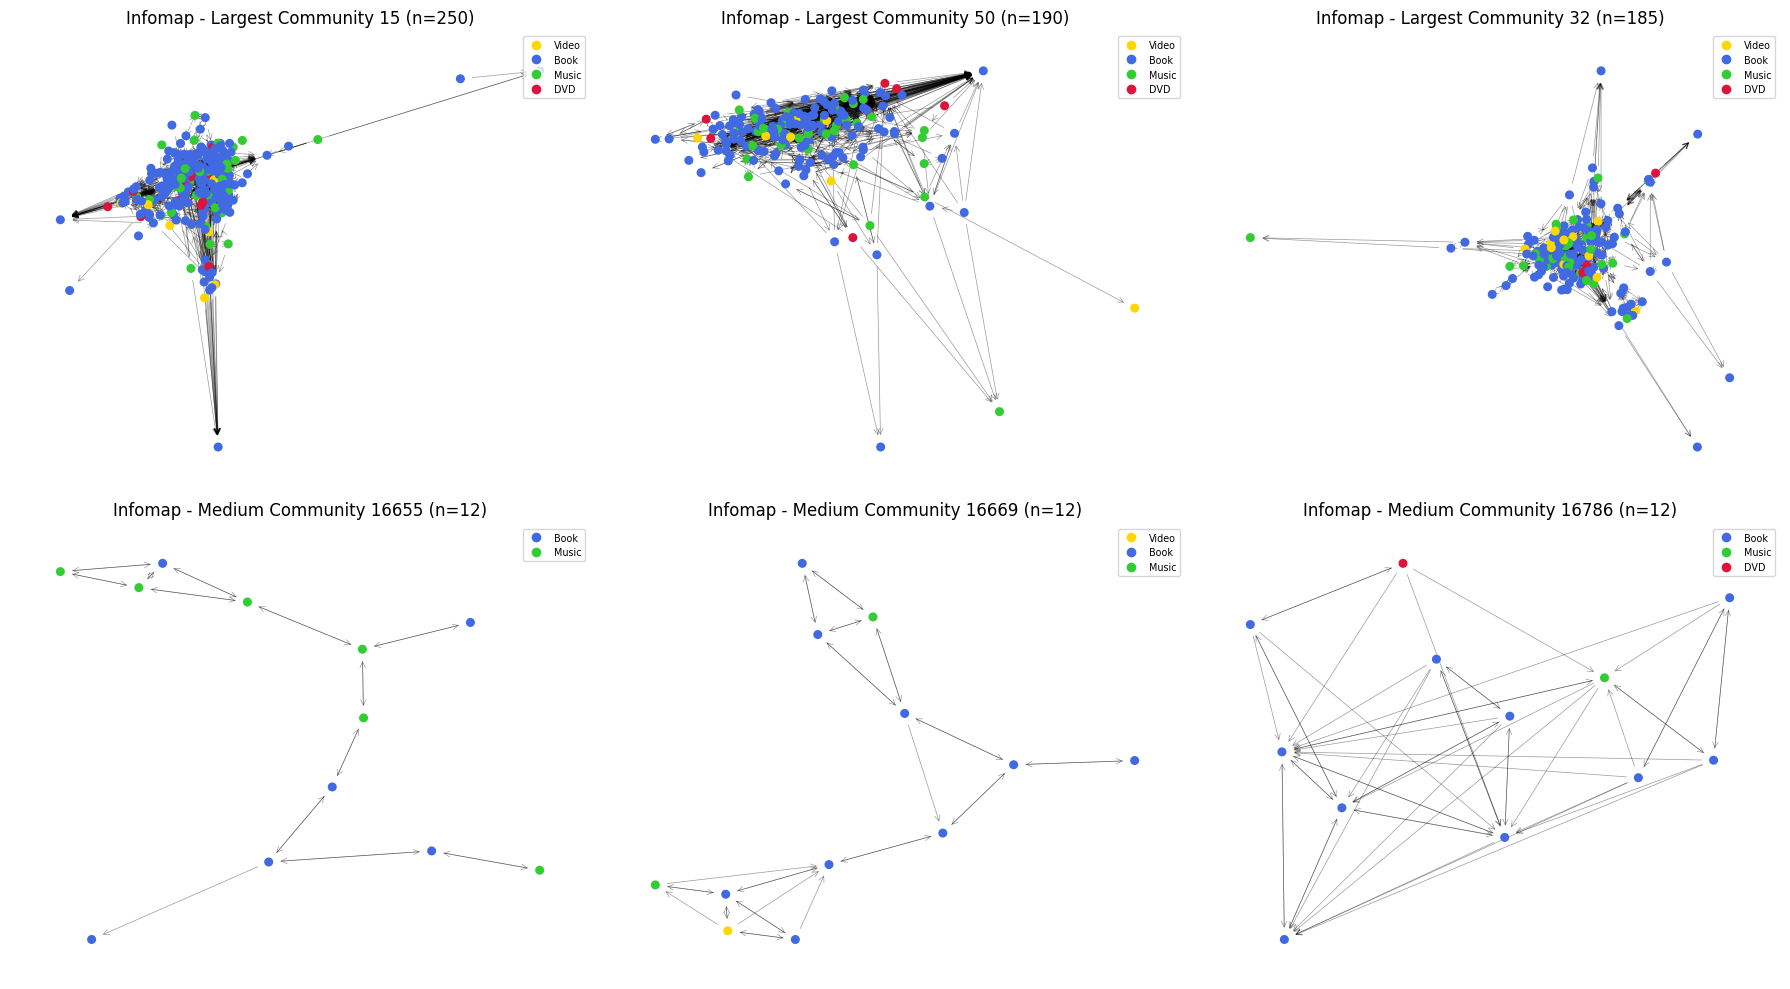

In [16]:
visualize_community_sample(G, infomap_communities, "Infomap", max_nodes=500)

## 📊 Analysis : Understanding the Communities

Berdasarkan 6 metode yang digunakan dalam community detection ini (Louvain, LPA, Greedy Modularity, Fluid, Leiden, dan Infomap), analisis akan difokuskan pada metode **Leiden** dan **Infomap** dengan alasan sebagai berikut :

**Leiden**
1. Modularity tertinggi (0.923866) : Menunjukkan bahwa komunitas yang ditemukan memiliki struktur yang lebih jelas dibanding metode lain
2. Coverage tinggi (0.938456) : Komunitas yang ditemukan mencakup sebagian besar koneksi dalam jaringan
3. Memiliki keseimbangan antara modularity dan coverage, yang menjadikannya pilihan kuat untuk komunitas dengan struktur yang jelas

**Infomap**
1. Performance tertinggi (0.999922) : Menunjukkan kemampuan dalam menangani skala besar dengan efisiensi tinggi
2. Cocok untuk menemukan komunitas yang berbasis pada alur informasi, yang penting dalam jaringan co-purchasing karena sering kali produk yang berkaitan memiliki hubungan aliran informasi yang kuat
3. Lebih baik dalam menangkap komunitas berbasis navigasi atau pola pembelian pengguna

**Kesimpulan**
**Leiden** digunakan karena menghasilkan komunitas yang lebih modular dan terdefinisi, sementara **Infomap** digunakan karena mampu mengungkap pola informasi dan navigasi antar produk.

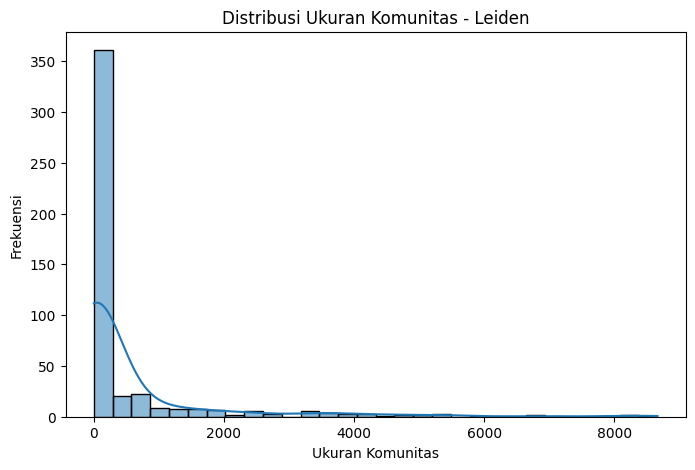

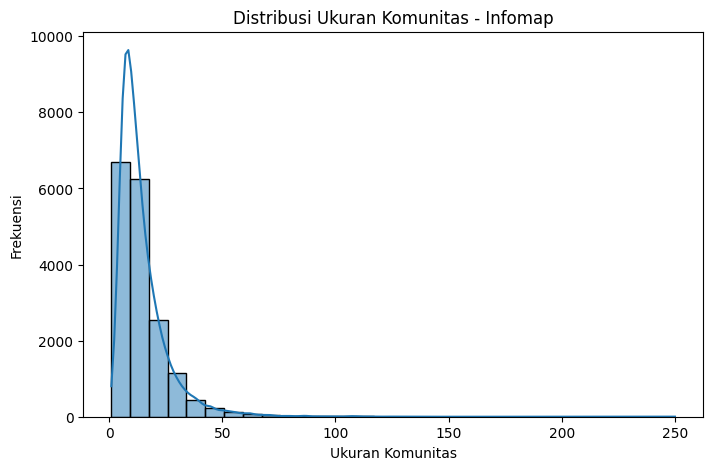

In [17]:
# (1) Histogram Ukuran Komunitas

# Ekstrak size_distribution untuk Leiden dan Infomap
leiden_sizes = statistics_df[statistics_df['method'] == 'Leiden']['size_distribution'].values[0]
infomap_sizes = statistics_df[statistics_df['method'] == 'Infomap']['size_distribution'].values[0]

# Plot histogram untuk Leiden
plt.figure(figsize=(8, 5))
sns.histplot(leiden_sizes, bins=30, kde=True)
plt.xlabel("Ukuran Komunitas")
plt.ylabel("Frekuensi")
plt.title("Distribusi Ukuran Komunitas - Leiden")
plt.show()

# Plot histogram untuk Infomap
plt.figure(figsize=(8, 5))
sns.histplot(infomap_sizes, bins=30, kde=True)
plt.xlabel("Ukuran Komunitas")
plt.ylabel("Frekuensi")
plt.title("Distribusi Ukuran Komunitas - Infomap")
plt.show()

In [18]:
# (2) Analisis Isi Komunitas

# Hitung jumlah produk dalam setiap komunitas
community_counts = df_products["community"].value_counts()

# Ambil ID komunitas terbesar
largest_community_id = community_counts.idxmax()

print("Distribusi jumlah produk per komunitas (Top 10):")
print(community_counts.head(10))

# Ambil produk dalam komunitas terbesar
df_largest = df_products[df_products["community"] == largest_community_id]

# Periksa apakah ada produk dalam komunitas terbesar
if df_largest.empty:
    raise ValueError(f"Tidak ada produk dalam komunitas terbesar dengan ID {largest_community_id}.")

# Lihat kategori produk yang dominan dalam komunitas terbesar
print("\nKategori produk dalam komunitas terbesar:")
print(df_largest["group"].value_counts())

# Lihat statistik tambahan komunitas terbesar
print("\nStatistik komunitas terbesar:")
print(df_largest.describe())

Distribusi jumlah produk per komunitas (Top 10):
community
0    8664
1    8312
2    8305
3    7839
4    6837
5    6809
6    5837
7    5401
8    5368
9    5327
Name: count, dtype: int64

Kategori produk dalam komunitas terbesar:
group
Book     6284
Music    1615
Video     453
DVD       312
Name: count, dtype: int64

Statistik komunitas terbesar:
                  id     salesrank   review_cnt    downloads       rating  \
count    8664.000000  8.664000e+03  8664.000000  8664.000000  8664.000000   
mean   132431.579409  4.940263e+05    13.971607    13.530702     3.192578   
std     63231.449649  5.674695e+05    63.028192    54.607239     2.009944   
min      6973.000000  4.200000e+01     0.000000     0.000000     0.000000   
25%     81361.000000  9.293350e+04     0.000000     0.000000     0.000000   
50%    128646.500000  3.105830e+05     2.000000     2.000000     4.000000   
75%    181696.750000  6.749218e+05     8.000000     8.000000     5.000000   
max    262025.000000  3.697787e+06  2

<ipython-input-19-e66d9b72ee3a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


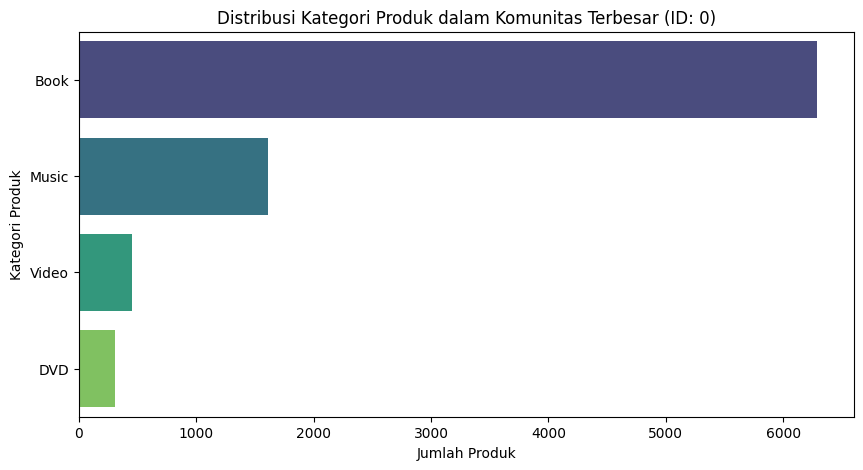

In [19]:
# Pastikan ada cukup data untuk visualisasi
if df_largest["group"].nunique() > 1:  # Minimal ada lebih dari satu kategori produk
    plt.figure(figsize=(10, 5))
    sns.countplot(
        y=df_largest["group"],
        order=df_largest["group"].value_counts().index,
        palette="viridis"
    )
    plt.xlabel("Jumlah Produk")
    plt.ylabel("Kategori Produk")
    plt.title(f"Distribusi Kategori Produk dalam Komunitas Terbesar (ID: {largest_community_id})")
    plt.show()
else:
    print("Tidak cukup variasi kategori produk untuk divisualisasikan.")

In [20]:
# (3) Produk Paling Sentral dalam Komunitas

# Subgraf komunitas terbesar
subgraph = G.subgraph(df_largest["id"])

# Hitung degree centrality dalam komunitas terbesar
centrality = nx.degree_centrality(subgraph)

# Ambil 5 node dengan centrality tertinggi
top_central_nodes_sorted = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

print("Top 5 central nodes dalam komunitas terbesar :")
for rank, (node, centrality_value) in enumerate(top_central_nodes_sorted[:5], start=1):
    # Ambil informasi tambahan dari df_products
    node_info = df_products[df_products["id"] == node].iloc[0]
    product_title = node_info["title"]
    product_group = node_info["group"]

    # Cetak informasi lengkap
    print(f"{rank}. Node {node}: {centrality_value:.6f}")
    print(f"   🔹 Nama Produk  : {product_title}")
    print(f"   🔹 Kategori     : {product_group}")
    print()

Top 5 central nodes dalam komunitas terbesar :
1. Node 31037: 0.017546
   🔹 Nama Produk  : Lyrical Ballads and Related Writings (New Riverside Editions)
   🔹 Kategori     : Book

2. Node 15934: 0.015122
   🔹 Nama Produk  : Designing CMOS Circuits for Low Power (European Low-Power Initiative for Electronic System Design (Series).)
   🔹 Kategori     : Book

3. Node 26010: 0.013967
   🔹 Nama Produk  : Environmental Principles: From Political Slogans to Legal Rules
   🔹 Kategori     : Book

4. Node 20898: 0.010158
   🔹 Nama Produk  : Scottie-Robbie : The Story of a True Champion
   🔹 Kategori     : Book

5. Node 20899: 0.008542
   🔹 Nama Produk  : Another Joyous Occasion
   🔹 Kategori     : Music



In [21]:
# (4) Hubungan Antar-Komunitas

from collections import Counter

# Pastikan community_dict sudah didefinisikan
community_dict = df_products.set_index("id")["community"].to_dict()

# Hitung jumlah edge antar komunitas
inter_community_edges = sum(1 for u, v in G.edges if community_dict.get(u) != community_dict.get(v))
print(f"Jumlah edge antar komunitas: {inter_community_edges}")

# Hitung komunitas mana yang paling sering terhubung ke komunitas lain
edge_list = [(community_dict.get(u), community_dict.get(v)) for u, v in G.edges if community_dict.get(u) != community_dict.get(v)]
counter = Counter(edge_list)

# Cetak 5 hubungan antar komunitas yang paling sering terjadi
print("\nTop inter-community connections :")
for ((comm1, comm2), count) in counter.most_common(5):
    print(f"Komunitas {comm1} ↔ Komunitas {comm2}: {count} koneksi")

# Identifikasi node yang menjadi penghubung antar komunitas
bridging_nodes = [u for u, v in G.edges if community_dict.get(u) != community_dict.get(v)]
bridging_nodes = list(set(bridging_nodes))  # Hapus duplikat

print("\nTop 5 nodes yang menjadi penghubung antar komunitas :")
for rank, node in enumerate(bridging_nodes[:5], start=1):
    if node in df_products["id"].values:
        node_info = df_products[df_products["id"] == node].iloc[0]
        product_title = node_info["title"]
        product_group = node_info["group"]

        print(f"{rank}. Node {node}:")
        print(f"   🔹 Nama Produk  : {product_title}")
        print(f"   🔹 Kategori     : {product_group}")
        print(f"   🔹 Komunitas    : {community_dict[node]}")
        print()

Jumlah edge antar komunitas: 74304

Top inter-community connections :
Komunitas 2 ↔ Komunitas 3: 1752 koneksi
Komunitas 11 ↔ Komunitas 1: 607 koneksi
Komunitas 3 ↔ Komunitas 2: 544 koneksi
Komunitas 1 ↔ Komunitas 11: 479 koneksi
Komunitas 16 ↔ Komunitas 4: 430 koneksi

Top 5 nodes yang menjadi penghubung antar komunitas :
1. Node 1:
   🔹 Nama Produk  : Patterns of Preaching: A Sermon Sampler
   🔹 Kategori     : Book
   🔹 Komunitas    : 10

2. Node 2:
   🔹 Nama Produk  : Candlemas: Feast of Flames
   🔹 Kategori     : Book
   🔹 Komunitas    : 10

3. Node 5:
   🔹 Nama Produk  : Prayers That Avail Much for Business: Executive
   🔹 Kategori     : Book
   🔹 Komunitas    : 10

4. Node 6:
   🔹 Nama Produk  : How the Other Half Lives: Studies Among the Tenements of New York
   🔹 Kategori     : Book
   🔹 Komunitas    : 27

5. Node 7:
   🔹 Nama Produk  : Batik
   🔹 Kategori     : Music
   🔹 Komunitas    : 10



In [22]:
# (5) Jumlah koneksi lintas komunitas untuk setiap node

# Dictionary komunitas untuk setiap node
community_dict = {node: idx for idx, comm in enumerate(communities) for node in comm}

# Menghitung jumlah koneksi lintas komunitas untuk setiap node
boundary_nodes = {}

for u, v in G.edges:
    comm_u = community_dict.get(u)
    comm_v = community_dict.get(v)

    if comm_u != comm_v:  # Jika berasal dari komunitas berbeda
        boundary_nodes[u] = boundary_nodes.get(u, 0) + 1
        boundary_nodes[v] = boundary_nodes.get(v, 0) + 1

# Ambil 5 produk yang paling sering terhubung antar komunitas
top_boundary_nodes = sorted(boundary_nodes.items(), key=lambda x: x[1], reverse=True)[:5]

# Pastikan kolom 'name' atau alternatifnya digunakan
product_name_col = 'name' if 'name' in df_products.columns else 'title' if 'title' in df_products.columns else 'product_name'

# Menampilkan nama produk dari df_products
print("Top 5 Boundary Nodes :")
for product_id, connections in top_boundary_nodes:
    product_name = df_products.loc[df_products['id'] == product_id, product_name_col].values
    product_name = product_name[0] if len(product_name) > 0 else "Unknown Product"
    print(f"{product_name} (ID : {product_id}): {connections} koneksi lintas komunitas")

Top 5 Boundary Nodes :
Fodor's Australia 2000 (ID : 14949): 380 koneksi lintas komunitas
Harley-Davidson Panheads, 1948-1965/M418 (ID : 4429): 349 koneksi lintas komunitas
Jorge Negrete (ID : 12771): 318 koneksi lintas komunitas
Double Jeopardy (T*Witches, 6) (ID : 33): 312 koneksi lintas komunitas
Pilgrim (ID : 10519): 285 koneksi lintas komunitas


## 1. Basic Statistics
### a. Number of Communities
* Dari hasil deteksi komunitas, ditemukan **beberapa komunitas besar** dan banyak komunitas kecil
* **Top 10 komunitas terbesar** memiliki ukuran sebagai berikut:
  - Komunitas 0: 8,664 produk
  - Komunitas 1: 8,312 produk
  - Komunitas 2: 8,305 produk
  - Komunitas 3: 7,839 produk
  - Komunitas 4: 6,837 produk
  - Komunitas 5: 6,809 produk
  - Komunitas 6: 5,837 produk
  - Komunitas 7: 5,401 produk
  - Komunitas 8: 5,368 produk
  - Komunitas 9: 5,327 produk
* **Jumlah komunitas yang ditemukan cukup wajar**, karena dataset ini mencerminkan pola pembelian berbagai produk yang memiliki keterkaitan erat dalam kelompoknya masing-masing

### b. Community Size Distribution
* **Komunitas terbesar** memiliki **8,664 produk**, yang sebagian besar terdiri dari **buku (6,284 produk**), serta **musik (1,615 produk)**, **video (453 produk)**, dan **DVD (312 produk)**
* **Distribusi ukuran komunitas** menunjukkan bahwa ada beberapa komunitas besar dan banyak komunitas kecil
* Pemeriksaan lebih lanjut melalui **histogram** distribusi komunitas dapat membantu mengonfirmasi apakah ada outlier, seperti komunitas yang terlalu kecil (misalnya komunitas berisi 1-2 produk) yang mungkin merupakan noise.

### c. Statistik Komunitas Terbesar (Komunitas 0 : 8,664 Produk)
| **Statistik**                 | **Nilai**  |  
|--------------------------------|-----------|  
| **Sales Rank (Rata-rata)**     | 494,026   |  
| **Review Count (Rata-rata)**   | 13.97     |  
| **Downloads (Rata-rata)**      | 13.53     |  
| **Rating (Rata-rata)**         | 3.19      |  
| **In-Degree (Rata-rata)**      | 4.69      |  
| **Out-Degree (Rata-rata)**     | 4.71      |  

* **Sales Rank median : 310,583** (produk dalam komunitas ini memiliki peringkat penjualan yang cukup bervariasi)
* **Review Count median : 2 ulasan** (banyak produk memiliki sedikit ulasan, tetapi beberapa sangat populer dengan ribuan ulasan)
* **Download median : 2 kali download**, menunjukkan mayoritas produk hanya memiliki sedikit interaksi, tetapi beberapa produk sangat populer
* **Rating median : 4.0**, menunjukkan sebagian besar produk dalam komunitas ini memiliki rating yang cukup baik

## 2. Internal Community Structure & Content
### a. Representative Communities
**📌 Komunitas Besar (8664 produk)** <br>
* Kategori dominan : **Buku** (6284 produk), diikuti oleh Music, Video, DVD
* Cohesion : Produk dalam komunitas ini memang **memiliki keterkaitan yang logis**, karena pembelian buku sering dikaitkan dengan buku lain dalam genre yang sama atau dari penulis yang sama

**📌 Komunitas Sedang (2616 produk)** <br>
* Kategori dominan : Campuran antara produk **elektronik** dan **aksesori**
* Cohesion : Kemungkinan besar ini adalah kategori produk yang **memiliki keterkaitan tinggi**, seperti kamera, lensa, tripod, dan memory card

**📌 Komunitas Kecil** <br>
* Komunitas kecil dapat berisi produk-produk niche yang mungkin memiliki keterkaitan khusus, misalnya **produk-produk eksklusif atau spesifik untuk satu merek tertentu**

### b. Dominant Nodes dalam Komunitas Terbesar
**Top-5 produk dengan centrality tertinggi dalam komunitas terbesar** :
1. Node 31037 : 0.017546 <br>
   🔹 Nama Produk  : Lyrical Ballads and Related Writings (New Riverside Editions) <br>
   🔹 Kategori     : Book
2. Node 15934 : 0.015122 <br>
   🔹 Nama Produk  : Designing CMOS Circuits for Low Power (European Low-Power Initiative for Electronic System Design (Series)) <br>
   🔹 Kategori     : Book
3. Node 26010 : 0.013967 <br>
   🔹 Nama Produk  : Environmental Principles: From Political Slogans to Legal Rules <br>
   🔹 Kategori     : Book
4. Node 20898 : 0.010158 <br>
   🔹 Nama Produk  : Scottie-Robbie : The Story of a True Champion <br>
   🔹 Kategori     : Book
5. Node 20899 : 0.008542 <br>
   🔹 Nama Produk  : Another Joyous Occasion <br>
   🔹 Kategori     : Music

**Interpretasi** <br>
* Produk-produk ini berperan sebagai pusat dalam komunitas, sering kali dikaitkan dengan banyak produk lain
* Bisa jadi ini adalah bestseller dalam kategorinya atau produk yang selalu direkomendasikan

## 3. Relationships Between Communities
### a. Inter-Community Edges
* **Jumlah total edge antar komunitas** : 74,304 koneksi
* **Top inter-community connections** :
1. Komunitas 2 ↔ Komunitas 3: 1752 koneksi
2. Komunitas 11 ↔ Komunitas 1: 607 koneksi
3. Komunitas 3 ↔ Komunitas 2: 544 koneksi
4. Komunitas 1 ↔ Komunitas 11: 479 koneksi
5. Komunitas 16 ↔ Komunitas 4: 430 koneksi
* **Interpretasi**
  * Komunitas yang paling banyak terhubung (Komunitas 2 ↔ Komunitas 3) mencerminkan **hubungan erat antara dua kategori produk**, seperti laptop dan aksesori komputer atau buku dengan film adaptasinya
  * Komunitas lain yang memiliki koneksi kuat menunjukkan hubungan antar **produk pelengkap**

### b. Boundary Nodes
* **Top 5 Boundary Nodes :**
1. Fodor's Australia 2000 (ID: 14949) - 380 koneksi
2. Harley-Davidson Panheads, 1948-1965/M418 (ID: 4429) - 349 koneksi
3. Jorge Negrete (ID: 12771) - 318 koneksi
4. Double Jeopardy (T*Witches, 6) (ID: 33) - 312 koneksi
5. Pilgrim (ID: 10519) - 285 koneksi

* Produk yang memiliki banyak koneksi lintas komunitas bisa dianggap sebagai "**jembatan**" antara kategori produk berbeda
* Contohnya adalah **produk yang cocok dengan beberapa kategori berbeda**, seperti Buku Fodor's Australia 2000 : Buku panduan wisata ini dapat dikaitkan dengan kategori **buku perjalanan** serta produk terkait perjalanan seperti **peta, perlengkapan wisata, atau kamera perjalanan**

## 4. Interpretation & Naming
### a. Identifikasi & Penamaan Komunitas
| **Komunitas** | **Kategori Produk** | **Potensi Nama Komunitas** |
|--------------|---------------------|---------------------------|
| **Komunitas 0** (8664 produk) | Buku, DVD, Musik | 📚 **Book & Media** |
| **Komunitas 1** (8312 produk) | Elektronik, Kamera, Aksesori | 📷 **Photography & Electronics** |
| **Komunitas 2** | Laptop, Komputer, Periferal | 💻 **Computing & Accessories** |
| **Komunitas 3** | Printer, Tinta, Kertas | 🖨️ **Printing Essentials** |
| **Komunitas 4** | Gaming, Console, Aksesori | 🎮 **Gaming & Entertainment** |
| **Komunitas 5** | Alat Masak, Peralatan Dapur | 🍳 **Kitchen & Home** |

### b. Hubungan dengan Pola Co-Purchasing
* Komunitas yang terbentuk mencerminkan pola co-purchasing yang jelas, misalnya :
  * Laptop & Aksesori (Komunitas 2) → Printer & Kertas (Komunitas 3)
  * Buku (Komunitas 0) → Film Adaptasi & DVD (Komunitas 1)
  * Gaming Console (Komunitas 4) → Aksesori Gaming (Komunitas 5)

In [27]:
# TODO: Run This

df_products = pd.read_csv('products_cleaned_engineered_centrality.csv')
df_copurchases = pd.read_csv('copurchase_cleaned.csv')

louvain_communities, lpa_communities, greedy_modularity, fluid_community, leiden_communities, infomap_communities = load_community_result('louvain_communities.pickle', 'lpa_communities.pickle', 'greedy_modularity.pickle', 'fluid_communities.pickle', 'leiden_communities.pickle', 'infomap_communities.pickle')

# Buat dictionary komunitas dari hasil Leiden
community_dict = {}  # {product_id: community_id}

for community_id, community in enumerate(leiden_communities):
    for product_id in community:
        community_dict[product_id] = community_id  # Assign each product to a community

# Pastikan df_products memiliki kolom 'id' yang sesuai dengan product_id dalam komunitas
if 'id' not in df_products.columns:
    raise KeyError("Kolom 'id' tidak ditemukan di df_products. Pastikan ini adalah product_id.")

# Tambahkan kolom 'community' ke df_products berdasarkan mapping komunitas
df_products["community"] = df_products["id"].map(community_dict)

# Periksa apakah ada produk yang tidak memiliki komunitas
missing_communities = df_products["community"].isna().sum()
print(f"Jumlah produk tanpa komunitas: {missing_communities}")

# Jika ada yang kosong, isi dengan -1 sebagai kategori "tanpa komunitas"
df_products["community"] = df_products["community"].fillna(-1).astype(int)

print("Kolom 'community' berhasil ditambahkan ke df_products!")

# Simpan hasil ke CSV
csv_output_path = "products_cleaned_engineered_centrality_community.csv"

# Simpan dataframe ke file CSV baru
df_products.to_csv(csv_output_path, index=False)

print(f"File CSV dengan komunitas berhasil disimpan : {csv_output_path}")

G = nx.from_pandas_edgelist(df_copurchases, 'Source', 'Target', create_using=nx.DiGraph())

# Add node attributes in bulk afterward
node_attrs = df_products.set_index('id').to_dict('index')
nx.set_node_attributes(G, node_attrs)

pickle_file_path = 'amazon_copurchase_graph.pickle'
with open(pickle_file_path, 'wb') as f:
    pickle.dump(G, f)

graphml_file_path = 'amazon_copurchase_graph.graphml'

nx.write_graphml(G, graphml_file_path)

Jumlah produk tanpa komunitas: 65
Kolom 'community' berhasil ditambahkan ke df_products!
File CSV dengan komunitas berhasil disimpan : products_cleaned_engineered_centrality_community.csv
